In [1]:
#library imports
import os
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_img = Path('/content/drive/MyDrive/Q3/images')
path_ann = Path('/content/drive/MyDrive/Q3/annotations')

In [8]:
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]

def Img_df (path_ann):
    annotations = filelist(path_ann, '.xml')
    ann_list = []
    for path_ann in annotations:
        root = ET.parse(path_ann).getroot()
        ann = {}
        ann['filename'] = Path(str(path_img) + '/'+ root.find("./filename").text)
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [9]:
df_train = Img_df(path_ann)

In [10]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [14]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[1],x[4],x[3]])

In [12]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [15]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Q3/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),30)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [16]:
X=[]
for i in range(0, 877):
  im = read_image(df_train.values[i][5])
  im_v=im.flatten()
  X.append(im_v)
X=np.array(X)

In [17]:
Y = df_train['new_bb'].to_numpy().copy()
Z =[]
for i in range(0,877):
  Z.append(Y[i])
Z= np.array(Z)
Y = Z

In [23]:
def MSE(X, Y, w_opt):
  Y_ = np.matmul(X, w_opt)
  err = 0
  for i in range(0,877):
    err += np.linalg.norm(Y_-Y)
  mse = err/877
  return mse

In [24]:
def MAE(X, Y, w_opt):
  Y_ = np.matmul(X, w_opt)
  err = 0
  for i in range(0,877):
    err += np.sum(np.absolute(Y_-Y))
  mae = err /(877*4)
  return mae

In [25]:
def MIOU(X, Y, w_opt):
  Y_ = np.matmul(X, w_opt)
  iou = 0
  for i in range(0,877):
    boxA = Y_[i]
    boxB = Y[i]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou += interArea / float(boxAArea + boxBArea - interArea)	
  miou = iou/877
  return miou

lambda: 0 MSE: 852224259.5380752 MSA: 9517792056.750782 MIOU: 1.822681420005934e-14
lambda: 1 MSE: 673519303.9407305 MSA: 7564945302.390932 MIOU: 6.838224302657563e-14
lambda: 2 MSE: 809412530.7785548 MSA: 9373196661.69824 MIOU: 0.0
lambda: 3 MSE: 2596201390.849622 MSA: 30105215224.608395 MIOU: 5.696458372624737e-13
lambda: 4 MSE: 1778044713.2592976 MSA: 20613926994.884335 MIOU: 3.5920169778578295e-13
lambda: 5 MSE: 10809629252.394346 MSA: 121492670112.29715 MIOU: 0.0
lambda: 6 MSE: 505251734.1361087 MSA: 5686933126.45988 MIOU: 1.1391236289036973e-12
lambda: 7 MSE: 443716373.5430339 MSA: 4955646213.344728 MIOU: 6.661074632781654e-13
lambda: 8 MSE: 18227525971.39645 MSA: 193561798780.90546 MIOU: 3.854376847750712e-15
lambda: 9 MSE: 334537047.16974056 MSA: 3774352794.876496 MIOU: 1.1276192560543447e-12


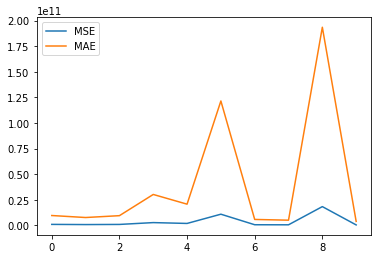

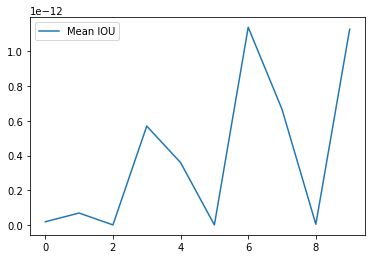

In [28]:
L = []
MSErr = []
MAErr = []
MeanIOU = []
# Ridge Regression 
for lam in range(0, 10):
  w_opt= np.matmul(np.linalg.pinv(np.matmul(X.T,X) - lam * np.eye(3960)),np.matmul(X.T,Y))
  mse = MSE(X, Y, w_opt)
  mae = MAE(X, Y, w_opt)
  miou = MIOU(X, Y, w_opt)
  L.append(lam)
  MSErr.append(mse)
  MAErr.append(mae)
  MeanIOU.append(miou)
  print('lambda:',lam, 'MSE:', mse,'MSA:', mae, 'MIOU:', miou)

plt.plot(MSErr)
plt.plot(MAErr)
 
plt.legend(["MSE", "MAE"])
plt.show()

plt.plot(MeanIOU)
plt.legend(["Mean IOU"])
plt.show()